# LMCs Layer Response Simulation

This example demonstrates how to simulate responses of LMCs neurons in layers L1, L2, and L3 to a sequence of brightness stimuli and plot their responses over time.

## Input

- **stimulus_frames** — 3D array of brightness stimuli, shape `(height, width, time)`  
- **NEURON_GRID** — grid size of neurons `(41, 41)`  
- **TIME_STEP** — simulation time step in ms (default `1`)  

## Parameters

| Parameter | Description | Example Value |
|-----------|-------------|---------------|
| `brightness_levels` | Sequence of brightness levels to present | `[0, 0.2, 0.4, 0.6, 0.8, 0.6, 0.4, 0.2, 0]` |
| `duration_per_level` | Duration of each brightness level in simulation steps | `10000` |
| `total_steps` | Total number of simulation steps | `90000` |
| `lmc_model` | Instance of `LMCs` model | `LMCs()` |

## Purpose

The simulation computes the temporal response of each neuron layer (L1, L2, L3) by applying the LMCs response function to the input stimulus. The responses are averaged across the neuron grid to provide a single trace per layer. Low-pass filtering and a non-linear activation (`SiLU`) are applied to the final outputs.

## Visualization

The layer responses are plotted over time using distinct colors for L1, L2, and L3, with axes labeled in seconds and responses:

- **L1** — golden (`#DDAA33`)  
- **L2** — magenta (`#BB5566`)  
- **L3** — cyan (`#66CCEE`)  

Grid lines are hidden, and top/right spines are removed for a clean visualization.


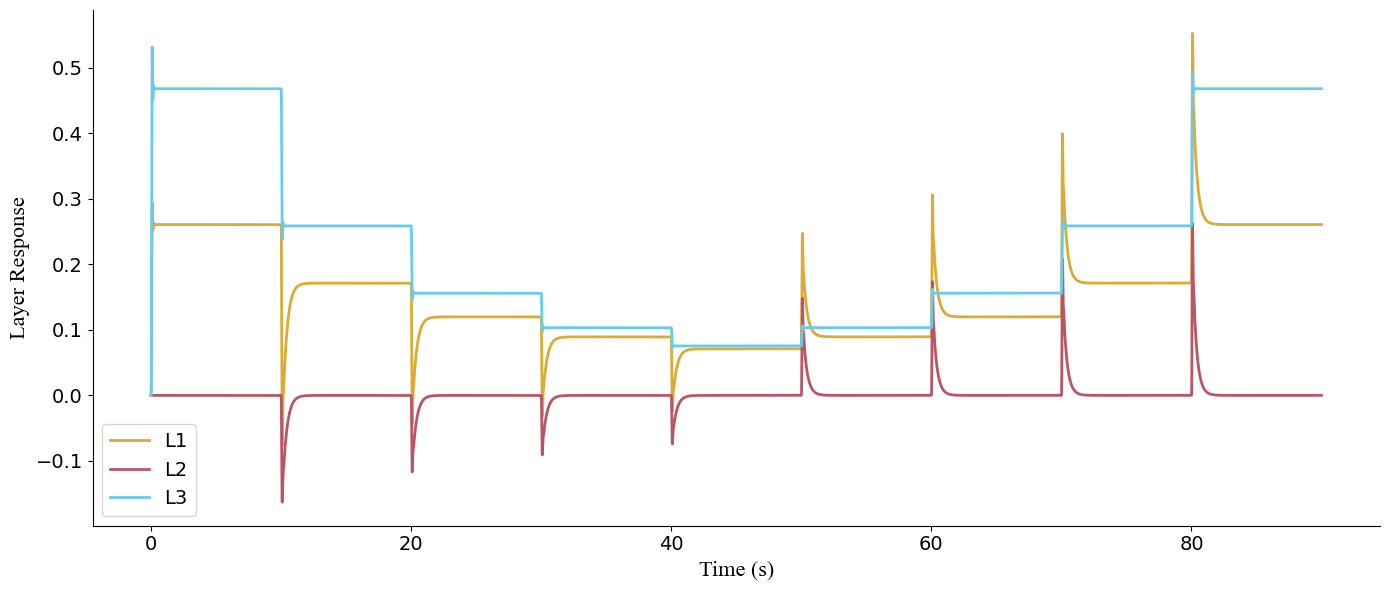

In [ ]:
import numpy as np
from data_process.LMCsResponse import LMCs
import matplotlib.pyplot as plt
from typing import Dict

def plot_layer_responses(layer_responses: Dict[str, np.ndarray], time: np.ndarray):
    """
    Plot L1-L3 responses over time.

    Parameters:
    - layer_responses: dictionary with keys 'L1', 'L2', 'L3' and values as response arrays
    - time: numpy array of time points in seconds
    """
    colors = {'L1': '#DDAA33', 'L2': '#BB5566', 'L3': '#66CCEE'}
    plt.figure(figsize=(10, 6))

    for layer, resp in layer_responses.items():
        plt.plot(time, resp, color=colors[layer], linewidth=2, label=layer)

    plt.xlabel('Time (s)', fontsize=16, family='Times New Roman')
    plt.ylabel('Layer Response', fontsize=16, family='Times New Roman')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(fontsize=14)
    plt.grid(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.tight_layout()
    plt.show()

# ---------------------------
# Initialize the LMCs model
# ---------------------------
lmc_model = LMCs()

# ---------------------------
# Generate brightness stimulus sequence
# Each level lasts 10s (10000 steps)
# ---------------------------
brightness_levels = [0, 0.2, 0.4, 0.6, 0.8, 0.6, 0.4, 0.2, 0]
duration_per_level = 10000
total_steps = duration_per_level * len(brightness_levels)

stimulus_frames = []
for level in brightness_levels:
    stimulus_frames.extend([np.full(lmc_model.NEURON_GRID, level)] * duration_per_level)
stimulus_frames = np.array(stimulus_frames)

# Rearrange to (height, width, time) for LMCs
stimulus_frames = np.transpose(stimulus_frames, (1, 2, 0))  # shape -> (41, 41, total_steps)

# ---------------------------
# Calculate L1-L3 layer responses
# ---------------------------
layer_responses = lmc_model.calculate_layer_responses(stimulus_frames)

# ---------------------------
# Plot L1-L3 responses
# ---------------------------
time = np.arange(total_steps) * lmc_model.TIME_STEP / 1000  # convert to seconds
plot_layer_responses(layer_responses, time)


# Function to read neuron IDs by type

In [ ]:
import csv

# ---------------------------
# Function to read neuron IDs by type
# ---------------------------
def read_neuron_ids(neuron_type, side=None, filename='./data/visual_neuron_types.txt'):
    neuron_ids = []
    try:
        with open(filename, 'r') as f:
            reader = csv.DictReader(f, delimiter=',')
            for row in reader:
                if row['type'] == neuron_type and (side is None or row['side'].lower() == side.lower()):
                    try:
                        neuron_ids.append(int(row['root_id']))
                    except ValueError:
                        continue
    except Exception as e:
        print(f"Error reading file: {str(e)}")
    return neuron_ids

# VFP Function Profile Response Simulation

This script simulates and plots the responses of visual neurons (e.g., Mi1) in Drosophila using the `LMCs` model.

## Steps

1. **Read neuron IDs** from a CSV file (`visual_neuron_types.txt`) by neuron type and hemisphere.
2. **Generate visual stimulus** over time, with specified brightness phases.
3. **Compute neuron responses** using `LMCs.calculate_response`.
4. **Plot responses** for each neuron over time.

Simulating Mi1: 100%|██████████| 10/10 [00:07<00:00,  1.27it/s]


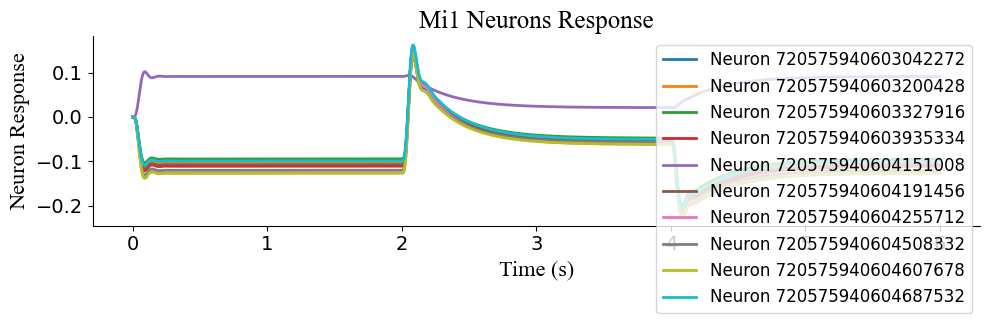

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from data_process.LMCsResponse import LMCs

# ---------------------------
# Initialize LMCs model
# ---------------------------
lmc_model = LMCs()

# ---------------------------
# Define stimulus phases
# ---------------------------
STIMULUS_PHASES = [
    (0, 2000, 0.2),
    (2000, 4000, 0.8),
    (4000, 6000, 0.2)
]

# ---------------------------
# Generate stimulus frames
# ---------------------------
raw_frames = []
for start, end, value in STIMULUS_PHASES:
    duration = end - start
    raw_frames.extend([np.full(lmc_model.NEURON_GRID, value)] * duration)

stimulus_frames = np.stack(raw_frames, axis=2)  # shape -> (41, 41, total_steps)
total_steps = stimulus_frames.shape[2]

# ---------------------------
# Define neuron types to simulate
# ---------------------------
neuron_types = ['Mi1']

# ---------------------------
# Simulation and plotting
# ---------------------------
time = np.arange(total_steps) * lmc_model.TIME_STEP / 1000  # seconds

for neuron_type in neuron_types:
    neuron_ids = read_neuron_ids(neuron_type, side='right')[:10]  # take first 10 neurons
    if not neuron_ids:
        print(f"No {neuron_type} neurons found")
        continue
    
    plt.figure(figsize=(10,3))
    plt.title(f"{neuron_type} Neurons Response", fontsize=18, family='Times New Roman')
    
    for neuron_id in tqdm(neuron_ids, desc=f'Simulating {neuron_type}'):
        try:
            weights = lmc_model.load_weights(neuron_id, side='100_8')
            response = lmc_model.calculate_response(stimulus_frames, weights)
            plt.plot(time, response, linewidth=2, label=f'Neuron {neuron_id}')
        except Exception as e:
            print(f"Error simulating neuron {neuron_id}: {str(e)}")
    
    plt.xlabel('Time (s)', fontsize=16, family='Times New Roman')
    plt.ylabel('Neuron Response', fontsize=16, family='Times New Roman')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.tight_layout()
    plt.show()


# DSI vs Preferred Angle Visualization for Neurons

This script computes the **Direction Selectivity Index (DSI)** and **preferred motion direction** for a set of neurons and visualizes them on polar (radar) plots.

Speed 2: 100%|████████████████████████████████████████████████████████| 5/5 [03:37<00:00, 43.57s/it]


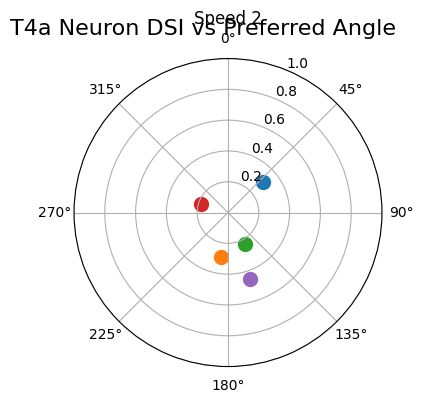

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from data_process.LMCsResponse import LMCs

# ----------------------------
# Configuration
# ----------------------------
NEURON_TYPE = "T4a"
SPEEDS = [2, 4, 8, 12, 16]                 # Motion speeds
DIRECTIONS = np.arange(0, 360, 30)         # Directions in degrees
EDGE_MOTION_DIR = './results/stimulus/EdgeMotion'
NUM_NEURONS = 5                            # Number of neurons to plot
PEAK_THRESHOLD = 0.1                        # Minimum peak difference to compute DSI

# ----------------------------
# Assume read_neuron_ids function is defined
# ----------------------------
neuron_ids = read_neuron_ids(NEURON_TYPE, side='right')[:NUM_NEURONS]

# ----------------------------
# Initialize system
# ----------------------------
system = LMCs()
response_system = system

# ----------------------------
# Preload stimuli
# ----------------------------
def preload_stimulus(stim_type='light_to_dark'):
    all_stim = {}
    for speed in SPEEDS:
        speed_dir = os.path.join(EDGE_MOTION_DIR, str(speed), stim_type)
        stim_dict = {}
        if not os.path.exists(speed_dir):
            all_stim[speed] = stim_dict
            continue
        for angle in DIRECTIONS:
            file_path = os.path.join(speed_dir, f'edge_motion_{angle}deg.npy')
            if os.path.exists(file_path):
                # Load and transpose stimulus data
                stim = np.load(file_path).transpose(1, 2, 0).astype(np.float32)
                stim_dict[angle] = stim
        all_stim[speed] = stim_dict
    return all_stim

stim_dicts = preload_stimulus('light_to_dark')

# ----------------------------
# Compute DSI and preferred angle for a neuron
# ----------------------------
def compute_dsi_and_pref_angle(neuron_id, stim_dict, peak_threshold=PEAK_THRESHOLD):
    weights = system.load_weights(neuron_id)
    peaks = []

    for angle in DIRECTIONS:
        stim = stim_dict.get(angle, None)
        if stim is None:
            peaks.append(0.0)
        else:
            # Calculate neuron response and take peak
            response = system.calculate_response(stim, weights)
            peak = np.max(np.maximum(response, 0))
            peaks.append(peak)

    peaks = np.array(peaks, dtype=np.float32)

    # Ignore if peak difference is below threshold
    if np.max(peaks) - np.min(peaks) < peak_threshold:
        return 0.0, -1  # DSI=0, invalid preferred angle

    # Compute DSI
    peaks_shifted = peaks - np.min(peaks)
    dsi = np.max(peaks_shifted) / (np.sum(peaks_shifted) + 1e-12)

    # Compute preferred direction using vector average
    angles_rad = np.deg2rad(DIRECTIONS)
    vec = np.sum(peaks_shifted * np.exp(1j * angles_rad))
    pref_angle = np.degrees(np.angle(vec)) % 360

    return dsi, pref_angle

# ----------------------------
# Plot polar (radar) chart
# ----------------------------
fig, axes = plt.subplots(1, len(SPEEDS), subplot_kw={'polar': True}, figsize=(20,4))
if len(SPEEDS) == 1:
    axes = [axes]

for i, speed in enumerate(SPEEDS):
    ax = axes[i]
    # Loop over neurons
    for neuron_id in tqdm(neuron_ids, desc=f"Speed {speed}", ncols=100):
        stim_dict = stim_dicts[speed]
        dsi, pref_angle = compute_dsi_and_pref_angle(neuron_id, stim_dict)
        if pref_angle >= 0:
            # Plot DSI as radial coordinate and preferred angle as theta
            ax.scatter(np.deg2rad(pref_angle), dsi, s=100, label=f'Neuron {neuron_id}')

    ax.set_title(f'Speed {speed}', fontsize=12)
    ax.set_theta_zero_location('N')   # Set zero angle at top (north)
    ax.set_theta_direction(-1)        # Clockwise direction
    ax.set_ylim(0, 1)                 # DSI range [0,1]

plt.suptitle(f'{NEURON_TYPE} Neuron DSI vs Preferred Angle', fontsize=16)
plt.show()